In [1]:
!pip3 install --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from torchvision import datasets


# Data Loading and Augmentation:

In [3]:
NO_AUG = transforms.Compose([ transforms.ToTensor()
                            ])

AUG = transforms.Compose([  transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ColorJitter(brightness= 0.2, contrast = 0.2 , saturation = 0.2),
                            transforms.RandomInvert(),
                            transforms.ToTensor()
                          ])

cifar_train_reg = torchvision.datasets.CIFAR10(root = 'data',
                                             train = True,
                                             download = True,
                                             transform = NO_AUG
                                             )
cifar_train_aug = torchvision.datasets.CIFAR10(root = 'data',
                                             train = True,
                                             download = True,
                                             transform = AUG
                                             )

cifar_test = torchvision.datasets.CIFAR10(root = 'data',
                                            train = False,
                                            download=True,
                                            transform = NO_AUG
                                          )

print(len(cifar_train_reg))
print(len(cifar_train_aug))
print(len(cifar_test))



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
50000
10000


<ipython-input-4-2bf589722c5a>:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(img.T)


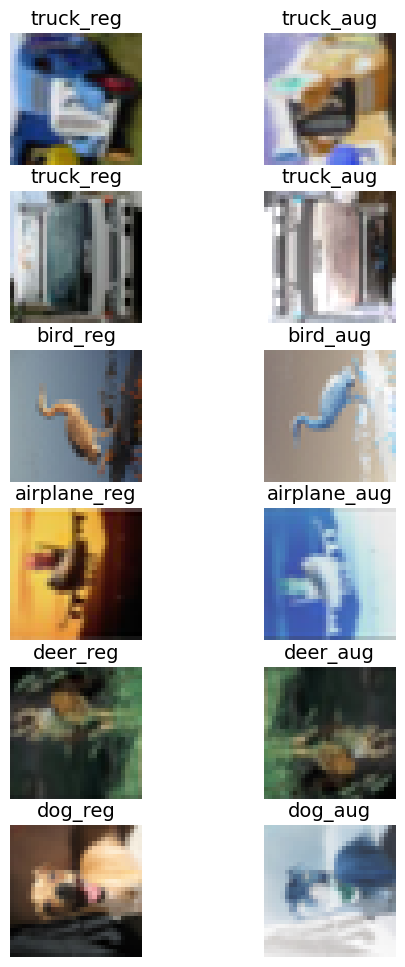

In [4]:
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


plt.style.use("seaborn-v0_8-whitegrid")
figsize = (6, 12)
figure = plt.figure(figsize=figsize)
rows = 6

for i in range(rows):
  idx = torch.randint(len(cifar_train_reg), size = (1,)).item()
  for j in range(2):
      if j==0:
        img, label = cifar_train_reg[idx]
        label = label_names[label] + "_reg"
      else:
        img, label = cifar_train_aug[idx]
        label = label_names[label] + "_aug"

      figure.add_subplot(rows, 2, i*2+j+1)
      plt.axis("off")
      plt.title(label, fontsize=14)
      plt.imshow(img.T)



In [5]:
batch_size = 64
train_reg_dl = DataLoader(cifar_train_reg, batch_size = batch_size, shuffle = True)
train_aug_dl = DataLoader(cifar_train_aug, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(cifar_test, batch_size = 64, shuffle = True)

# Building a ConvNet:

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.lin1 = nn.Linear(16*128, 512)
        self.lin2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()


    def forward(self, inp):
        out = self.relu(self.conv1(inp))
        out = self.maxpool(out)

        out = self.relu(self.conv2(out))
        out = self.maxpool(out)


        out = self.relu(self.conv3(out))
        out = self.maxpool(out)


        out = self.flatten(out)
        out = self.relu(self.lin1(out))
        out = self.dropout(out)
        out = self.lin2(out)

        return out

In [7]:
model_reg = ConvNet()
model_aug = ConvNet()

# Training:

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=1e-3)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-3)


In [ ]:
def train(model, loss_func, optimizer, dataloader, epochs):
    loss_hist = []
    acc_hist = []

    model.train()
    for i in range(epochs):
        print("Epoch {:d} of {:d}:".format(i+1, epochs))
        epoch_loss = 0
        epoch_acc = 0
        for j, (imgs, labels) in enumerate(dataloader):

            probs = model(imgs)
            vals, preds = torch.max(probs, 1)

            loss = loss_func(probs, labels)
            corr = torch.sum(preds == labels.data)

            if ((j+1)% 100 == 0):
                print("\t For batch {:d}: Loss: {:f}, Accuracy: {:f}".format(j+1, loss.item()/batch_size, float(corr.item())/batch_size))


            epoch_loss += loss.item()
            epoch_acc += corr.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss /= len(dataloader)
        epoch_acc  /= len(dataloader)
        print("Epoch {:d}: Training Loss: {:f}, Accuracy: {:f} \n".format(i+1, epoch_loss, epoch_acc))

        loss_hist.append(epoch_loss)
        acc_hist.append(epoch_acc)
    return(loss_hist, acc_hist)

loss_hist_reg, acc_hist_reg = train(model_reg, loss_func=loss_func, optimizer=optimizer_reg, dataloader=train_aug_dl, epochs=8)
loss_hist_aug, acc_hist_aug = train(model_aug, loss_func=loss_func, optimizer=optimizer_aug, dataloader=train_aug_dl, epochs=8)

Epoch 1 of 8:
	 For batch 100: Loss: 0.036102, Accuracy: 0.109375
	 For batch 200: Loss: 0.030374, Accuracy: 0.281250
	 For batch 300: Loss: 0.031743, Accuracy: 0.250000
	 For batch 400: Loss: 0.030170, Accuracy: 0.281250
	 For batch 500: Loss: 0.026219, Accuracy: 0.390625
	 For batch 600: Loss: 0.024811, Accuracy: 0.484375
	 For batch 700: Loss: 0.026512, Accuracy: 0.390625
Epoch 1: Training Loss: 1.948315, Accuracy: 17.081841 

Epoch 2 of 8:
	 For batch 100: Loss: 0.026771, Accuracy: 0.406250
	 For batch 200: Loss: 0.026902, Accuracy: 0.375000
	 For batch 300: Loss: 0.026856, Accuracy: 0.437500
	 For batch 400: Loss: 0.021751, Accuracy: 0.468750
	 For batch 500: Loss: 0.025965, Accuracy: 0.406250
	 For batch 600: Loss: 0.024774, Accuracy: 0.375000
	 For batch 700: Loss: 0.022144, Accuracy: 0.468750
Epoch 2: Training Loss: 1.615591, Accuracy: 26.121483 

Epoch 3 of 8:
	 For batch 100: Loss: 0.026807, Accuracy: 0.328125
	 For batch 200: Loss: 0.020650, Accuracy: 0.421875
	 For batch 30

# Testing:

In [ ]:
plt.figsize = (5, 5)
plt.style.use("seaborn-v0_8-whitegrid")

plt.plot(loss_hist_reg, label="Reg Loss")
plt.plot(loss_hist_aug, label="Aug Loss")
plt.title("Comparing Augmented and Regular Loss")
plt.legend()
plt.show()


plt.plot(acc_hist_reg, label="Reg Acc")
plt.plot(acc_hist_aug, label="Aug Acc")
plt.title("Comparing Augmented and Regular Accuracy")
plt.legend()
plt.show()

In [ ]:
def test(model, dataloader):
    total_loss = 0
    total_corr = 0
    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:


            probs = model(imgs)
            vals, preds = torch.max(probs, 1)

            total_loss = loss_func(probs, labels).item()
            total_corr += torch.sum(preds == labels).item()

        avg_loss = total_loss / len(dataloader)
        acc  = float(total_corr)/len(dataloader)
        print("Testing Loss: {:f}, Accuracy: {:f}".format(avg_loss, acc))

test(model_reg, test_dl)
test(model_aug, test_dl)


In [ ]:
idxs = 25
imgs, labels = next(iter(test_dl))
img, label = imgs[idx], label_names[labels[idx].item()]
plt.title(label)
plt.imshow(img.T)
plt.axis("off")
plt.show()

features_reg = model_reg.conv1(img)
features_aug = model_aug.conv1(img)

figsize = (6, 12)
figure = plt.figure(figsize=figsize)

rows = 8
for i in range(rows):
  for j in range(4):
      if j % 2 ==0:
        img = features_reg[i+j/2].T.detach().numpy()
      else:
        img = features_aug[i+(j-1)/2].T.detach().numpy()
      figure.add_subplot(rows, 2, i*2+j+1)
      plt.axis("off")
      plt.title("Feature {:d}".format(i), fontsize=14)
      plt.imshow(img)
plt.show()


In [ ]:
torch.save(model_reg.state_dict(), "./cifar10reg.pth")
torch.save(model_aug.state_dict(), "./cifar10aug.pth")